In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from data.data_preprocessing import load_data, text_cleaning
from sklearn.preprocessing import LabelEncoder
import joblib
import os

# Load data

In [27]:
df = load_data('data/intents.csv')

In [28]:
df.head()

,sentence,intent
0,Lịch học hôm nay của tôi là gì?,lich_hoc
1,Cho tôi xem thời khóa biểu tuần này.,lich_hoc
2,Ngày mai tôi có tiết học nào không?,lich_hoc
3,TKB của tui tuần sau như thế nào?,lich_hoc
4,Hôm nay tôi học môn gì và ở đâu?,lich_hoc


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 602 entries, 0 to 601
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  602 non-null    object
 1   intent    602 non-null    object
dtypes: object(2)
memory usage: 9.5+ KB


In [30]:
df.describe()

,sentence,intent
count,602,602
unique,602,5
top,Lịch học hôm nay của tôi là gì?,diem_so
freq,1,167


# Preprocess data

In [31]:
df['sentence'] = df['sentence'].apply(lambda s: text_cleaning(s))

In [32]:
df.head()

,sentence,intent
0,lich hoc hom nay cua toi_la gi ?,lich_hoc
1,cho toi xem thoi_khoa bieu tuan nay .,lich_hoc
2,ngay mai_toi co_tiet hoc nao khong ?,lich_hoc
3,tkb cua tui tuan sau nhu_the nao ?,lich_hoc
4,hom nay toi hoc mon_gi va o dau ?,lich_hoc


# Target variable encoding

In [33]:
label_encoder = LabelEncoder()
df['intent_encoded'] = label_encoder.fit_transform(df['intent'])

In [34]:
df[['intent', 'intent_encoded']].value_counts()

intent     intent_encoded
diem_so    1                 167
lich_hoc   3                 130
diem_danh  0                 114
lich_thi   4                 100
hoc_phi    2                  91
Name: count, dtype: int64

# Split data

In [35]:
X_train, X_test, y_train, y_test = train_test_split(df['sentence'], df['intent_encoded'], test_size=0.2, random_state=42, stratify=df['intent_encoded'])

# Vectorize features

In [36]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Define models

In [37]:
models = {
    "Multinomial Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(random_state=42),
    "Support Vector Machine": SVC(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
}

# Train models

### A. Base Model

In [38]:
results = {}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    results[model_name] = {
        'model': model,
        'report': classification_report(y_test, y_pred, output_dict=True, zero_division=0),
        'accuracy': accuracy_score(y_test, y_pred),
        'confusion': confusion_matrix(y_test, y_pred)
    }

### B. GridSearchCV

In [82]:
param_grids = {
    "Logistic Regression": {
        "C": np.logspace(-4,4,20),
        "solver": ["liblinear"],
    },
    "Support Vector Machine": {
        "C": [1, 5, 10]
    },
    "Random Forest": {
        "n_estimators": [100, 200, 300, 400, 500]
    }
}

In [83]:
results_grid = {}

for model_name, model in models.items():
    if model_name in param_grids:
        clf = GridSearchCV(model, param_grid = param_grids[model_name], cv = 3, verbose=False, n_jobs=-1)
        best_clf = clf.fit(X_train, y_train)
        model = best_clf.best_estimator_
        print("Best hyperparameters of", model_name, "is:", end=" ")
        try:
            print(model.best_params_)
        except:
            print(model)
    else:
        continue
    y_pred = model.predict(X_test)

    results_grid[model_name] = {
        'model': model,
        'report': classification_report(y_test, y_pred, output_dict=True, zero_division=0),
        'accuracy': accuracy_score(y_test, y_pred),
        'confusion': confusion_matrix(y_test, y_pred)
    }

Best hyperparameters of Logistic Regression is: LogisticRegression(C=np.float64(11.288378916846883), random_state=42,
                   solver='liblinear')
Best hyperparameters of Support Vector Machine is: SVC(C=5, random_state=42)
Best hyperparameters of Random Forest is: RandomForestClassifier(n_estimators=400, random_state=42)


# Evaluate models

In [84]:
metrics = []

for model_name, result in results.items():
    precision = round(result['report']['weighted avg']['precision'], 3)
    recall = round(result['report']['weighted avg']['recall'], 3)
    f1 = round(result['report']['weighted avg']['f1-score'], 3)
    acc = round(result['accuracy'], 3)

    if model_name in results_grid:
        precision_tuned = round(results_grid[model_name]['report']['weighted avg']['precision'], 3)
        precision_delta = round(precision_tuned - precision, 3)
        recall_tuned = round(results_grid[model_name]['report']['weighted avg']['recall'], 3)
        recall_delta = round(recall_tuned - recall, 3)
        f1_tuned = round(results_grid[model_name]['report']['weighted avg']['f1-score'], 3)
        f1_delta = round(f1_tuned - f1, 3)
        acc_tuned = round(results_grid[model_name]['accuracy'], 3)
        acc_delta = round(acc_tuned - acc, 3)
        
    metric = {
        'Model': model_name,
        'Precision': round(precision, 3),
        'Precision Tuned': f"{round(precision_tuned, 3)} Δ{"+" if precision_delta >= 0 else "-"}{precision_delta}" if model_name in results_grid else None,
        'Recall': round(recall, 3),
        'Recall Tuned': f"{round(recall_tuned, 3)} Δ{"+" if recall_delta >= 0 else "-"}{recall_delta}" if model_name in results_grid else None,
        'F1-Score': round(f1, 3),
        'F1-Score Tuned': f"{round(f1_tuned, 3)} Δ{"+" if f1_delta >= 0 else "-"}{f1_delta}" if model_name in results_grid else None,
        'Accuracy': round(acc, 3),
        'Accuracy Tuned': f"{round(acc_tuned, 3)} Δ{"+" if acc_delta >= 0 else "-"}{acc_delta}" if model_name in results_grid else None
    }

    metrics.append(metric)

pd.DataFrame(metrics)

,Model,Precision,Precision Tuned,Recall,Recall Tuned,F1-Score,F1-Score Tuned,Accuracy,Accuracy Tuned
0,Multinomial Naive Bayes,0.922,None,0.917,None,0.916,None,0.917,None
1,Logistic Regression,0.953,0.976 Δ+0.023,0.950,0.975 Δ+0.025,0.951,0.975 Δ+0.024,0.950,0.975 Δ+0.025
2,Support Vector Machine,0.960,0.969 Δ+0.009,0.959,0.967 Δ+0.008,0.959,0.967 Δ+0.008,0.959,0.967 Δ+0.008
3,Random Forest,0.944,0.952 Δ+0.008,0.942,0.95 Δ+0.008,0.942,0.95 Δ+0.008,0.942,0.95 Δ+0.008


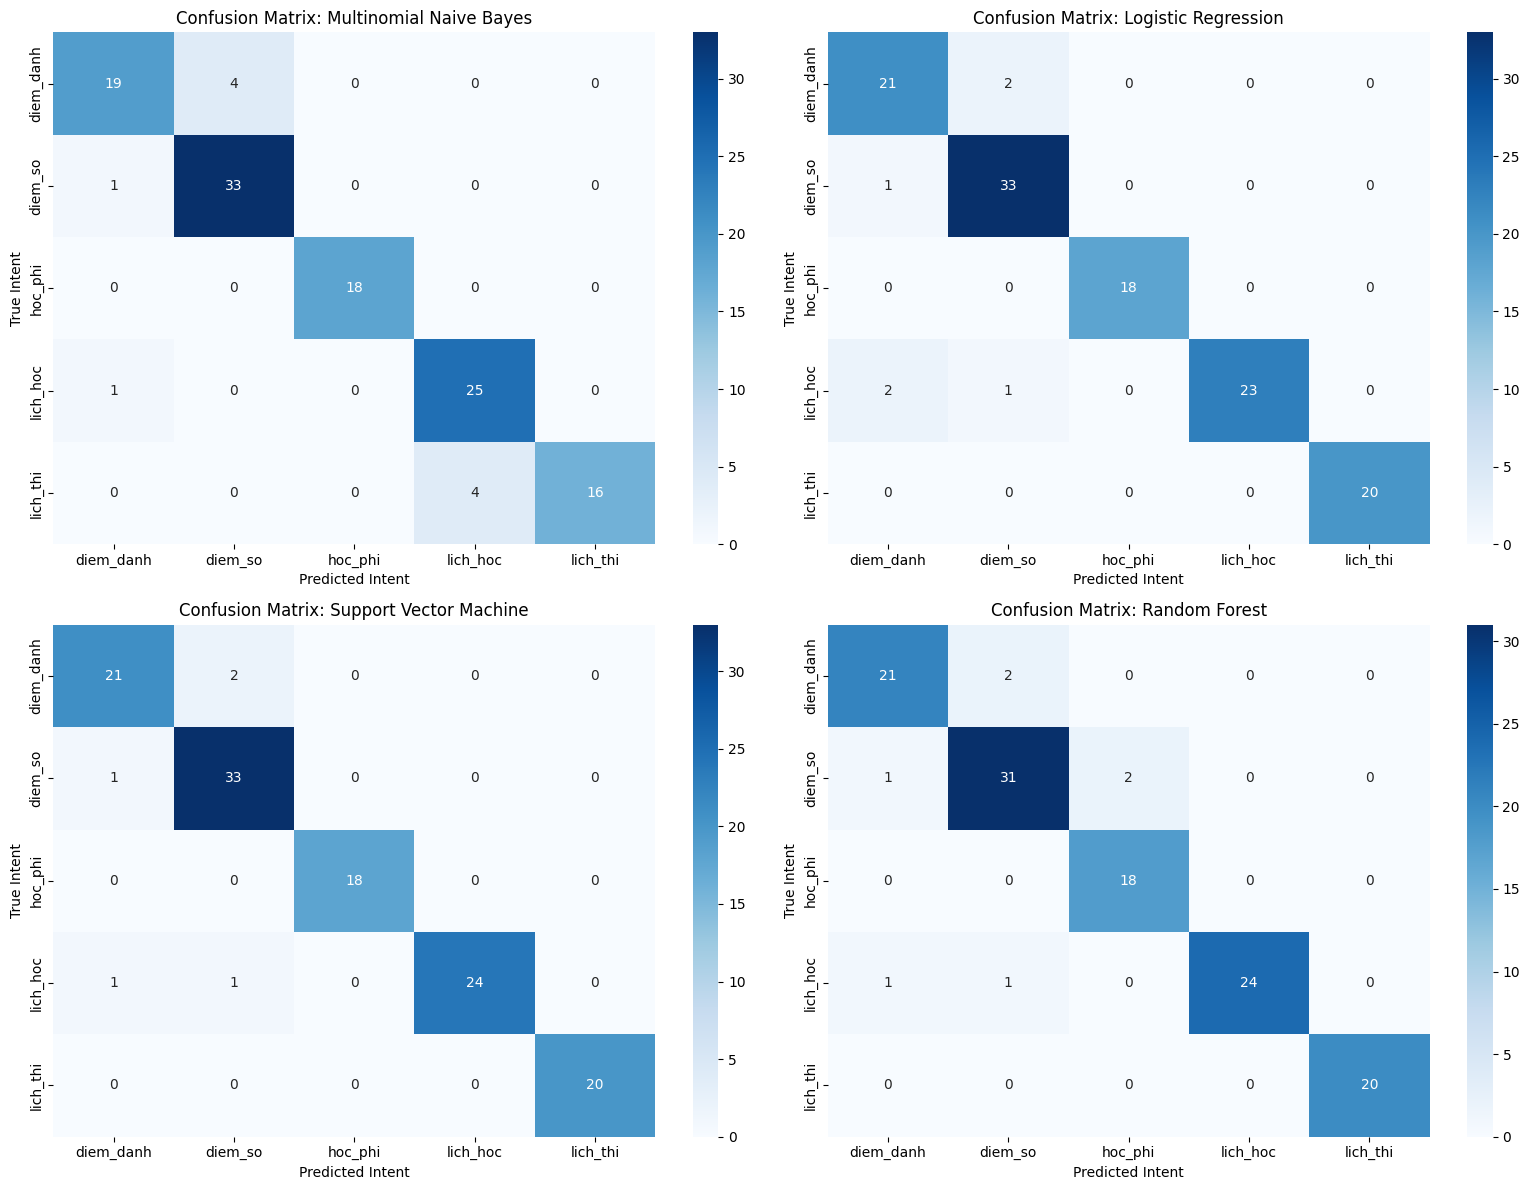

In [42]:
intent_classes = label_encoder.inverse_transform(np.unique(y_test))
plt.figure(figsize=(16,12))
for i, (model_name, results_) in enumerate(results.items()):
    plt.subplot(2, 2, i+1)
    sns.heatmap(results_['confusion'], annot=True, fmt="d", cmap="Blues", xticklabels=intent_classes, yticklabels=intent_classes)
    plt.xlabel('Predicted Intent')
    plt.ylabel('True Intent')
    plt.title(f'Confusion Matrix: {model_name}')
plt.tight_layout()
plt.show()

# Save model

In [43]:
metrics_df = pd.DataFrame(metrics)
best_model_name = metrics_df.sort_values('Accuracy', ascending=False).iloc[0]['Model']
model = results[best_model_name]['model']
os.makedirs('models', exist_ok=True)
joblib.dump(model, f"models/best_model.pkl")
joblib.dump(vectorizer, 'models/vectorizer.pkl')
joblib.dump(label_encoder, "intent_encoding.pkl")

['intent_encoding.pkl']

# Test model

In [90]:
input_text = "check diem danh mon ail303m cua toi"

cleaned_text = text_cleaning(input_text)
transformed_text = vectorizer.transform([cleaned_text])

predicted_intent = model.predict(transformed_text)
predicted_proba = model.predict_proba(transformed_text)[0]

predicted_confidence = np.max(predicted_proba) * 100

predicted_intent_label = label_encoder.inverse_transform([predicted_intent])[0]
print(f"Predicted Intent: {predicted_intent_label} (Confidence: {predicted_confidence:.2f}%)")

print("\nProbabilities for all intents:")
intent_classes = label_encoder.classes_
for intent, prob in zip(intent_classes, predicted_proba):
    print(f"{intent}: {prob*100:.2f}%")


Predicted Intent: diem_danh (Confidence: 68.75%)

Probabilities for all intents:
diem_danh: 68.75%
diem_so: 9.25%
hoc_phi: 0.00%
lich_hoc: 14.25%
lich_thi: 7.75%
